# File 2: Data Preprocessing for Machine Learning
## Stock Price Volatility & Sentiment ML Project

**Purpose:** Prepare data for machine learning models

**What we'll do:**
1. Load the final dataset
2. Separate features and target variable
3. Feature scaling (StandardScaler)
4. Train/Test split (80/20, time-based)
5. Correlation analysis
6. PCA dimensionality reduction
7. Save preprocessed data for model training


## Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✅ Libraries loaded successfully!')

✅ Libraries loaded successfully!


## Step 2: Load Final Dataset

In [2]:
# Load final dataset
# UPDATE THIS PATH
df = pd.read_csv('/Users/aryan/Desktop/Stock-Price-Volatility-Sentiment-ML/data/final_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])

print(f'Dataset loaded!')
print(f'   Shape: {df.shape}')
print(f'   Date range: {df["Date"].min().date()} to {df["Date"].max().date()}')

Dataset loaded!
   Shape: (3705, 26)
   Date range: 2020-12-31 to 2025-12-01


## Step 3: Separate Features and Target

We'll separate our data into:
- **X (features):** All the indicators and metrics we'll use to predict
- **y (target):** Price_Direction (0=Down, 1=Up)

In [3]:
# Define feature columns (everything except Date, Ticker, and Target)
feature_cols = [
    # Price features
    'Close', 'Open', 'High', 'Low', 'Volume',
    # Technical indicators
    'RSI', 'EMA_20', 'EMA_50', 
    'MACD', 'MACD_Signal', 'MACD_Hist',
    'BB_Upper', 'BB_Middle', 'BB_Lower', 'BB_Width',
    # Price metrics
    'Price_Change', 'Volatility_20', 'Daily_Return', 'High_Low_Range',
    # Sentiment features
    'Sentiment_Score', 'Sentiment_Positive_Ratio', 
    'Sentiment_Negative_Ratio', 'Daily_Sentiment'
]

# Separate features (X) and target (y)
X = df[feature_cols].copy()
y = df['Price_Direction'].copy()

# Keep Date and Ticker for reference
dates = df['Date'].copy()
tickers = df['Ticker'].copy()

print(f'Features (X): {X.shape}')
print(f'Target (y): {y.shape}')
print(f'\nTarget distribution:')
print(f'   Up (1): {y.sum()} ({y.mean()*100:.1f}%)')
print(f'   Down (0): {(y==0).sum()} ({(1-y.mean())*100:.1f}%)')

Features (X): (3705, 23)
Target (y): (3705,)

Target distribution:
   Up (1): 1935 (52.2%)
   Down (0): 1770 (47.8%)


## Step 4: Check for Missing Values

# Check for missing values
print('Checking for missing values in features...')
missing = X.isnull().sum()

if missing.sum() == 0:
    print('✅ No missing values found!')
else:
    print('⚠️ Missing values found:')
    print(missing[missing > 0])
    print('\nFilling missing values with mean...')
    X = X.fillna(X.mean())
    print('✅ Missing values filled')

## Step 5: Feature Correlation Analysis

Let's see which features are highly correlated with each other

In [4]:
# Calculate correlation matrix
print('Calculating feature correlations...')
correlation_matrix = X.corr()

# Find highly correlated pairs (>0.9)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

print(f'\nFound {len(high_corr_pairs)} highly correlated feature pairs (>0.9):')
for feat1, feat2, corr in high_corr_pairs[:10]:  # Show first 10
    print(f'   {feat1} <-> {feat2}: {corr:.3f}')

if len(high_corr_pairs) > 10:
    print(f'   ... and {len(high_corr_pairs) - 10} more')

Calculating feature correlations...

Found 37 highly correlated feature pairs (>0.9):
   Close <-> Open: 0.998
   Close <-> High: 0.999
   Close <-> Low: 0.999
   Close <-> EMA_20: 0.989
   Close <-> EMA_50: 0.972
   Close <-> BB_Upper: 0.977
   Close <-> BB_Middle: 0.984
   Close <-> BB_Lower: 0.968
   Open <-> High: 0.999
   Open <-> Low: 0.999
   ... and 27 more


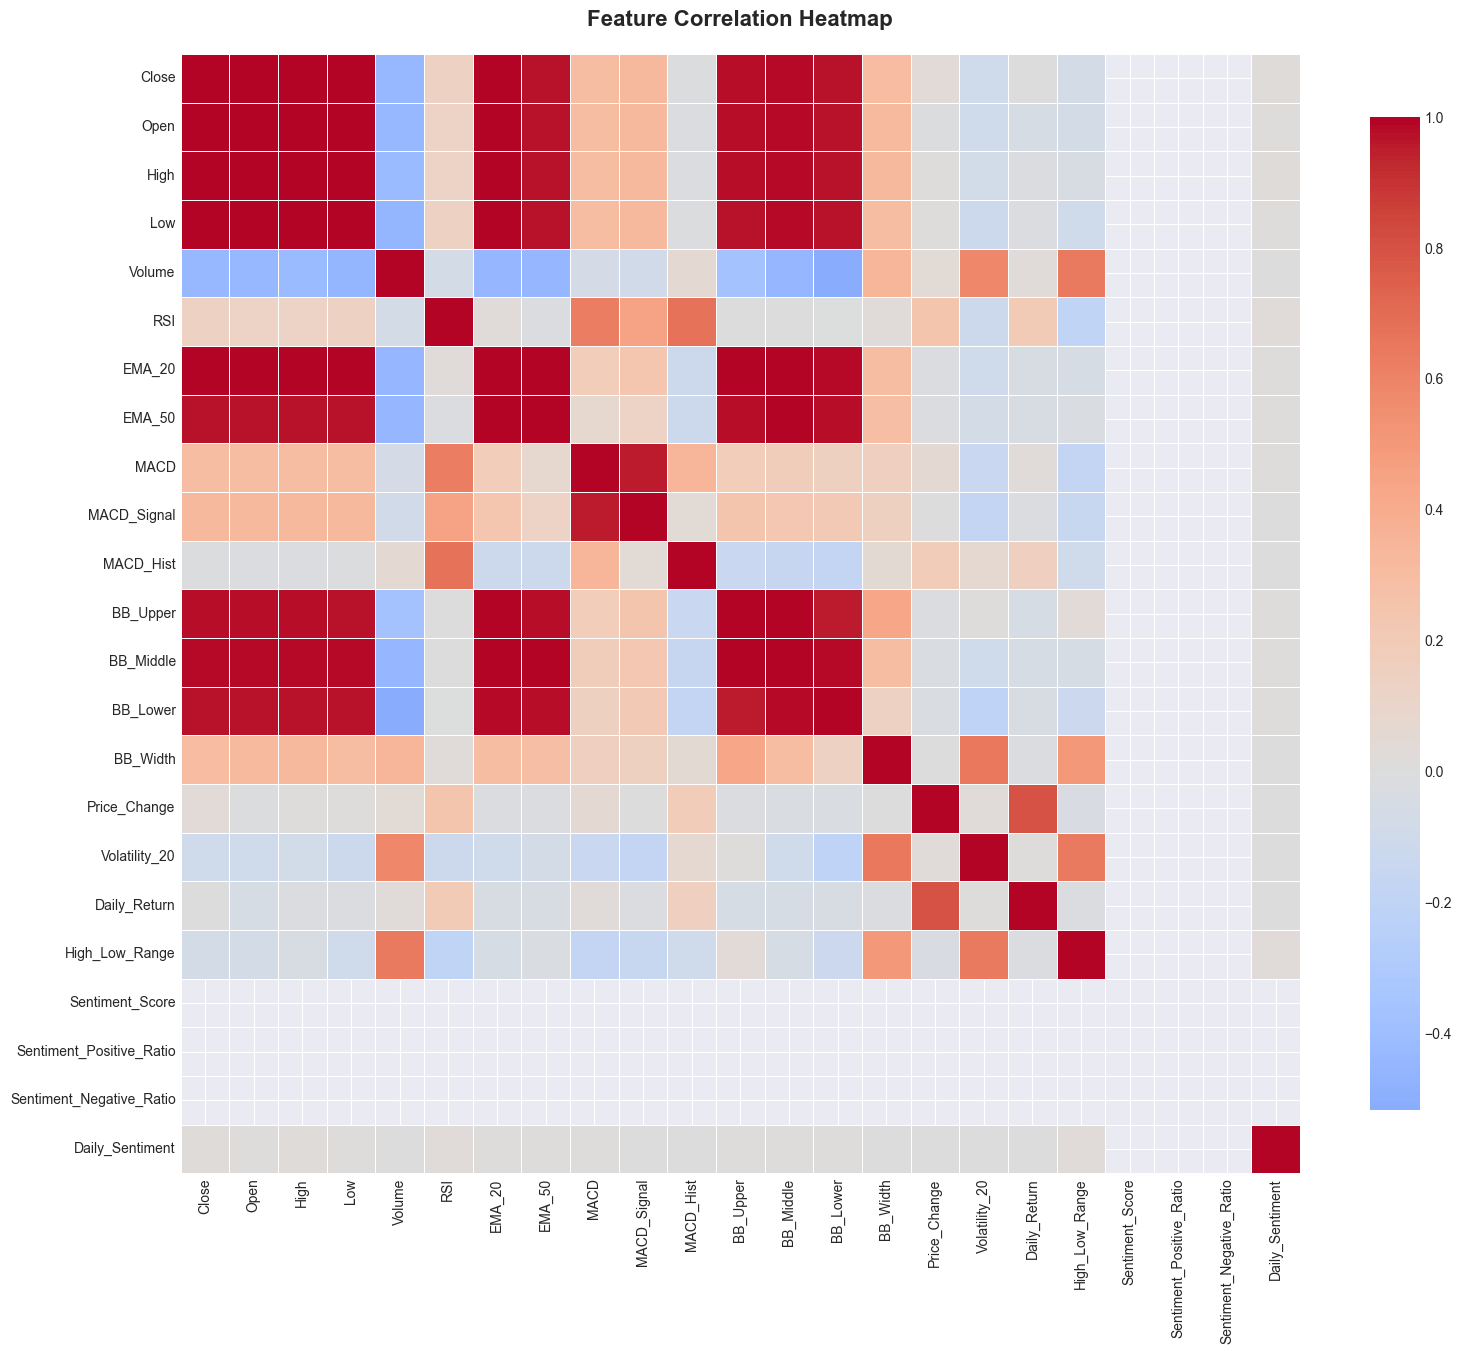

✅ Saved: 02_correlation_heatmap.png


In [5]:
# Visualize correlation heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('/Users/aryan/Desktop/Stock-Price-Volatility-Sentiment-ML/visualizations/02_correlation_heatmap.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print('✅ Saved: 02_correlation_heatmap.png')

## Step 6: Train/Test Split (Time-Based)

**IMPORTANT:** We use time-based split, NOT random split!

Why? Because:
- Stock data is time-series data
- We can't use future data to predict the past
- We train on older data, test on newer data

Split: 80% train (older), 20% test (newer)

In [6]:
print('='*70)
print('TRAIN/TEST SPLIT (TIME-BASED)')
print('='*70)

# Create a combined DataFrame for sorting by date
temp_df = pd.DataFrame(X)
temp_df['Date'] = dates.values
temp_df['Target'] = y.values
temp_df['Ticker'] = tickers.values

# Sort by date
temp_df = temp_df.sort_values('Date').reset_index(drop=True)

# Split point: 80% train, 20% test
split_idx = int(len(temp_df) * 0.8)

# Split the data
train_df = temp_df.iloc[:split_idx]
test_df = temp_df.iloc[split_idx:]

# Extract features and target
X_train = train_df[feature_cols].values
y_train = train_df['Target'].values
X_test = test_df[feature_cols].values
y_test = test_df['Target'].values

print(f'\nDataset split:')
print(f'   Total samples: {len(temp_df):,}')
print(f'   Train samples: {len(X_train):,} ({len(X_train)/len(temp_df)*100:.1f}%)')
print(f'   Test samples: {len(X_test):,} ({len(X_test)/len(temp_df)*100:.1f}%)')

print(f'\nDate ranges:')
print(f'   Train: {train_df["Date"].min().date()} to {train_df["Date"].max().date()}')
print(f'   Test: {test_df["Date"].min().date()} to {test_df["Date"].max().date()}')

print(f'\nTarget distribution:')
print(f'   Train - Up: {y_train.sum()}/{len(y_train)} ({y_train.mean()*100:.1f}%)')
print(f'   Test - Up: {y_test.sum()}/{len(y_test)} ({y_test.mean()*100:.1f}%)')

print('\n✅ Time-based split complete!')

TRAIN/TEST SPLIT (TIME-BASED)

Dataset split:
   Total samples: 3,705
   Train samples: 2,964 (80.0%)
   Test samples: 741 (20.0%)

Date ranges:
   Train: 2020-12-31 to 2024-12-04
   Test: 2024-12-05 to 2025-12-01

Target distribution:
   Train - Up: 1547/2964 (52.2%)
   Test - Up: 388/741 (52.4%)

✅ Time-based split complete!


## Step 7: Feature Scaling

We use StandardScaler to normalize features:
- Mean = 0
- Standard deviation = 1

This is crucial for SVM and Neural Networks!

In [7]:
print('='*70)
print('FEATURE SCALING')
print('='*70)

# Create scaler
scaler = StandardScaler()

# Fit on training data and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('\n✅ Features scaled using StandardScaler')
print(f'\nScaled training data:')
print(f'   Mean (should be ~0): {X_train_scaled.mean(axis=0)[:5]}')
print(f'   Std (should be ~1): {X_train_scaled.std(axis=0)[:5]}')

FEATURE SCALING

✅ Features scaled using StandardScaler

Scaled training data:
   Mean (should be ~0): [-1.82190445e-16 -1.91779416e-17  1.91779416e-16  1.91779416e-17
  6.47255529e-17]
   Std (should be ~1): [1. 1. 1. 1. 1.]


## Step 8: PCA Analysis

PCA (Principal Component Analysis) reduces dimensions while keeping most information.

Goal: Reduce 23 features to fewer components (target: 95% variance)

In [8]:
print('='*70)
print('PCA ANALYSIS')
print('='*70)

# Apply PCA with all components to see variance
pca_full = PCA()
pca_full.fit(X_train_scaled)

# Calculate explained variance
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Find number of components for 95% and 90% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

print(f'\nPCA Results:')
print(f'   Total features: {len(feature_cols)}')
print(f'   Components for 95% variance: {n_components_95}')
print(f'   Components for 90% variance: {n_components_90}')
print(f'   Variance explained by top 5 components: {cumulative_variance[4]:.1%}')

PCA ANALYSIS

PCA Results:
   Total features: 23
   Components for 95% variance: 7
   Components for 90% variance: 6
   Variance explained by top 5 components: 88.2%


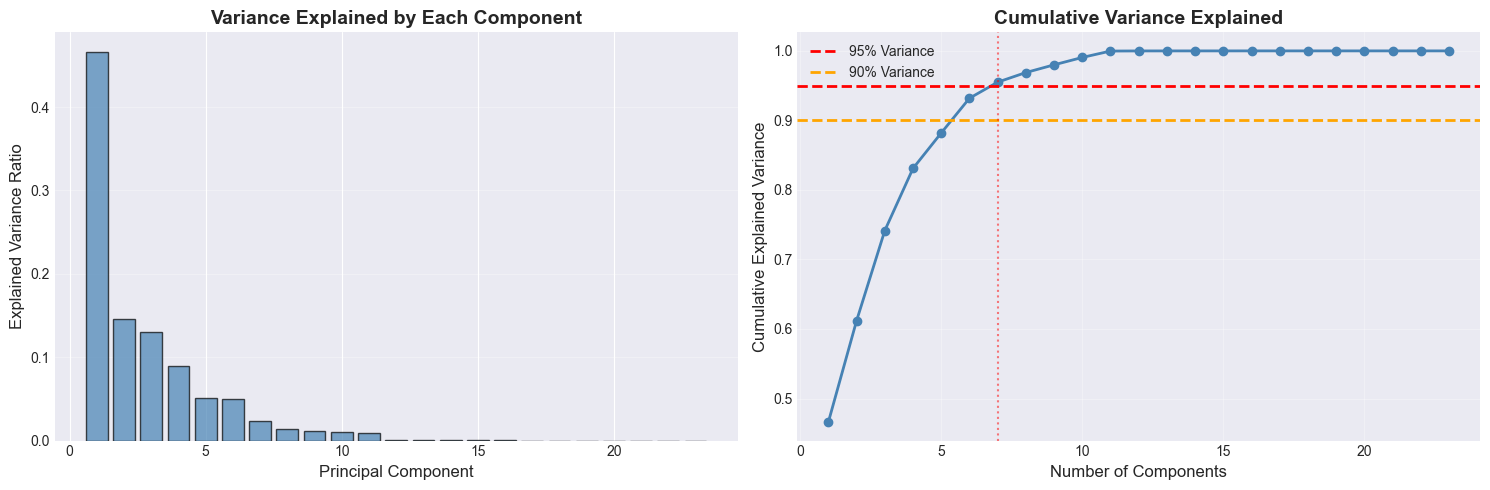

✅ Saved: 02_pca_analysis.png


In [9]:
# Visualize PCA variance
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Individual variance per component
axes[0].bar(range(1, len(explained_variance)+1), explained_variance, 
            color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('Variance Explained by Each Component', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')

# Cumulative variance
axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance, 
             marker='o', linewidth=2, markersize=6, color='steelblue')
axes[1].axhline(y=0.95, color='red', linestyle='--', linewidth=2, label='95% Variance')
axes[1].axhline(y=0.90, color='orange', linestyle='--', linewidth=2, label='90% Variance')
axes[1].axvline(x=n_components_95, color='red', linestyle=':', alpha=0.5)
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Variance Explained', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/aryan/Desktop/Stock-Price-Volatility-Sentiment-ML/visualizations/02_pca_analysis.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print('✅ Saved: 02_pca_analysis.png')

In [10]:
# Apply PCA with optimal number of components (95% variance)
pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f'\n✅ PCA applied!')
print(f'   Original features: {X_train_scaled.shape[1]}')
print(f'   PCA features: {X_train_pca.shape[1]}')
print(f'   Variance retained: {cumulative_variance[n_components_95-1]:.2%}')


✅ PCA applied!
   Original features: 23
   PCA features: 7
   Variance retained: 95.50%


## Step 9: Save Preprocessed Data

We'll save everything we need for model training:
- Scaled data (full features)
- PCA-reduced data
- Target variables
- Scaler and PCA objects (for future predictions)

In [11]:
print('='*70)
print('SAVING PREPROCESSED DATA')
print('='*70)

# Create processed folder if needed
import os
processed_dir = '/Users/aryan/Desktop/Stock-Price-Volatility-Sentiment-ML/data/processed'
os.makedirs(processed_dir, exist_ok=True)

# Save numpy arrays
np.save(f'{processed_dir}/X_train_scaled.npy', X_train_scaled)
np.save(f'{processed_dir}/X_test_scaled.npy', X_test_scaled)
np.save(f'{processed_dir}/X_train_pca.npy', X_train_pca)
np.save(f'{processed_dir}/X_test_pca.npy', X_test_pca)
np.save(f'{processed_dir}/y_train.npy', y_train)
np.save(f'{processed_dir}/y_test.npy', y_test)

print('✅ Saved numpy arrays:')
print('   - X_train_scaled.npy')
print('   - X_test_scaled.npy')
print('   - X_train_pca.npy')
print('   - X_test_pca.npy')
print('   - y_train.npy')
print('   - y_test.npy')

# Save scaler and PCA objects
joblib.dump(scaler, f'{processed_dir}/scaler.pkl')
joblib.dump(pca, f'{processed_dir}/pca.pkl')

print('\n✅ Saved models:')
print('   - scaler.pkl')
print('   - pca.pkl')

# Save feature names
with open(f'{processed_dir}/feature_names.txt', 'w') as f:
    f.write('\n'.join(feature_cols))

print('\n✅ Saved feature_names.txt')

SAVING PREPROCESSED DATA
✅ Saved numpy arrays:
   - X_train_scaled.npy
   - X_test_scaled.npy
   - X_train_pca.npy
   - X_test_pca.npy
   - y_train.npy
   - y_test.npy

✅ Saved models:
   - scaler.pkl
   - pca.pkl

✅ Saved feature_names.txt
